# Baseline

papers: 

- Network modelling methods for FMRI. Smith et al., 2011.

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
print(torch.__version__)

1.3.1


## Import data

In [3]:
sim1 = sio.loadmat('data/sims_fMRI/sim1.mat')
sim1_ts = sim1['ts']
sim1_net = sim1['net']
print(sim1_ts.shape)
print(sim1_net.shape)

(10000, 5)
(50, 5, 5)


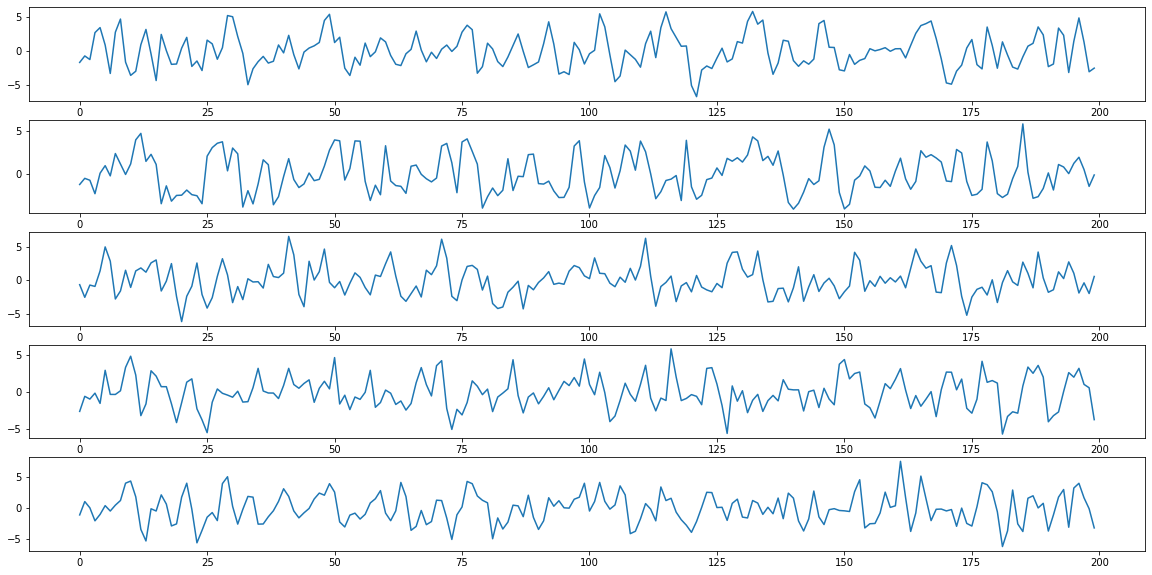

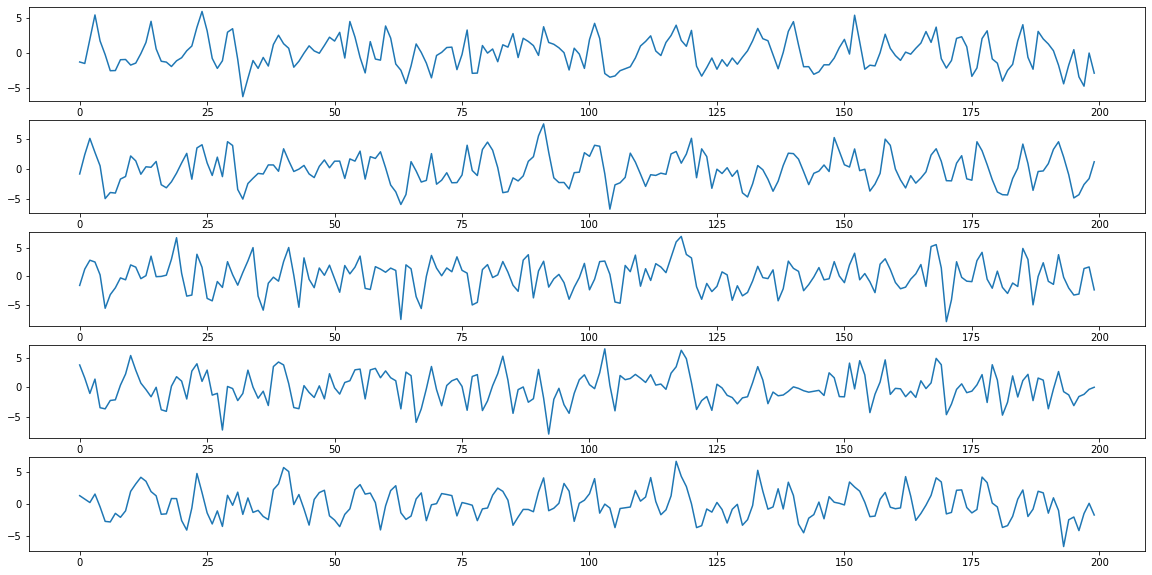

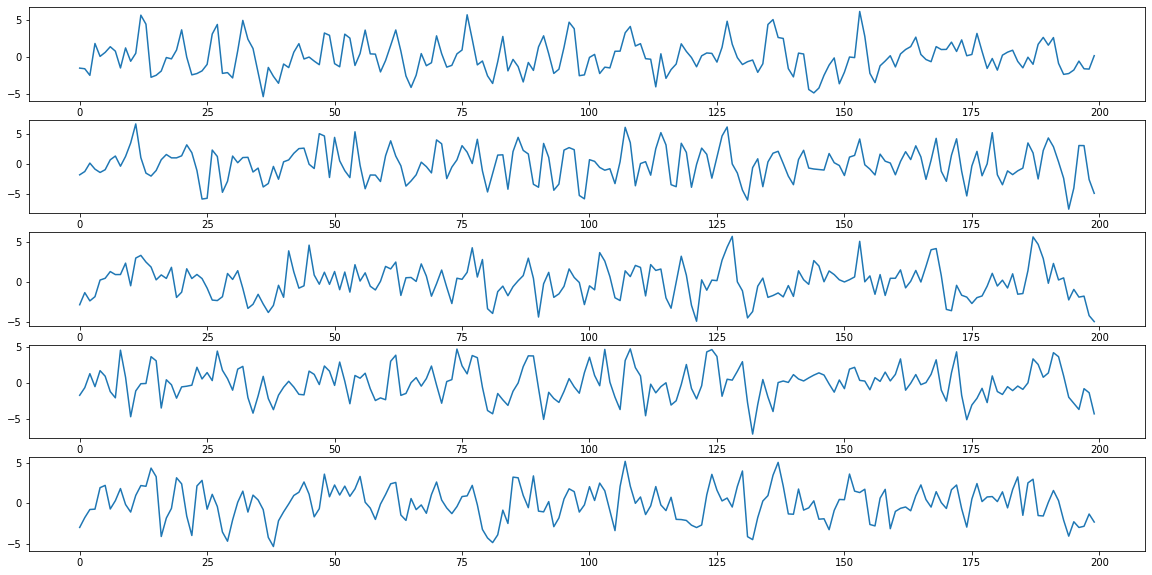

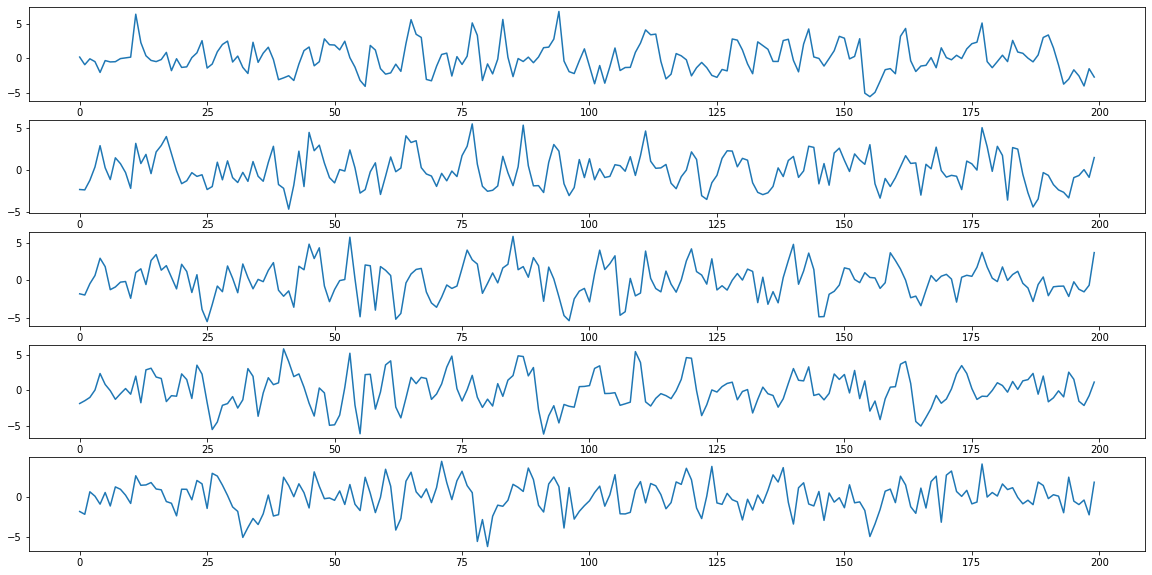

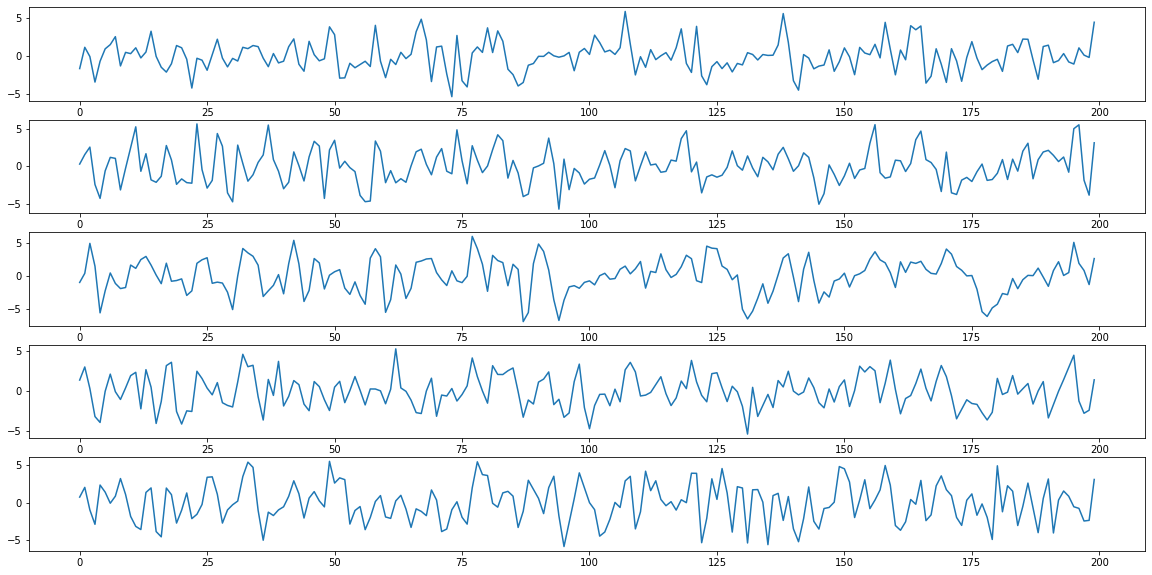

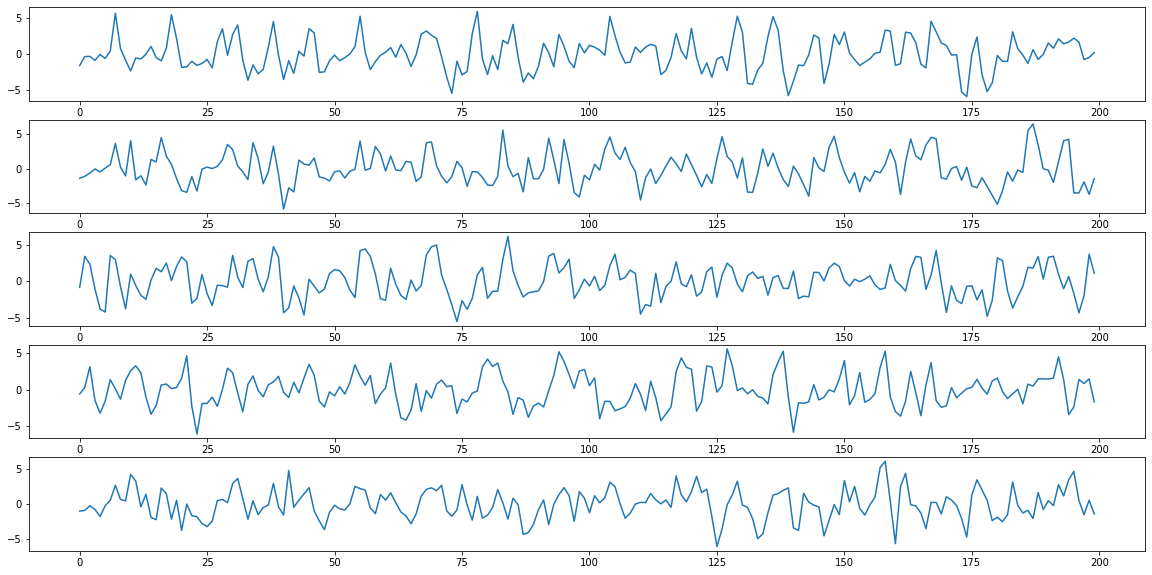

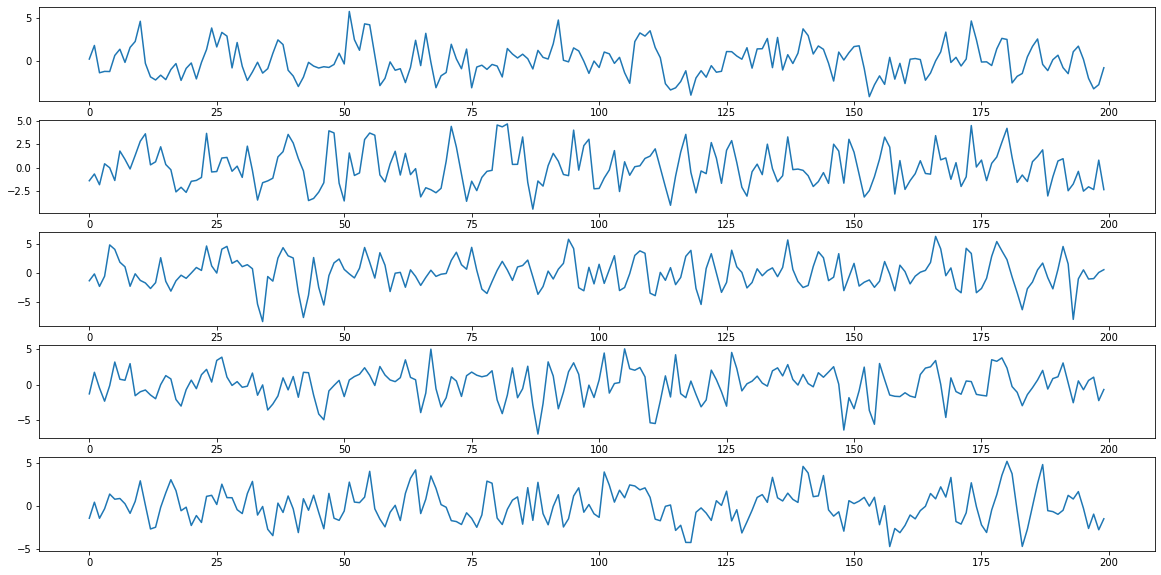

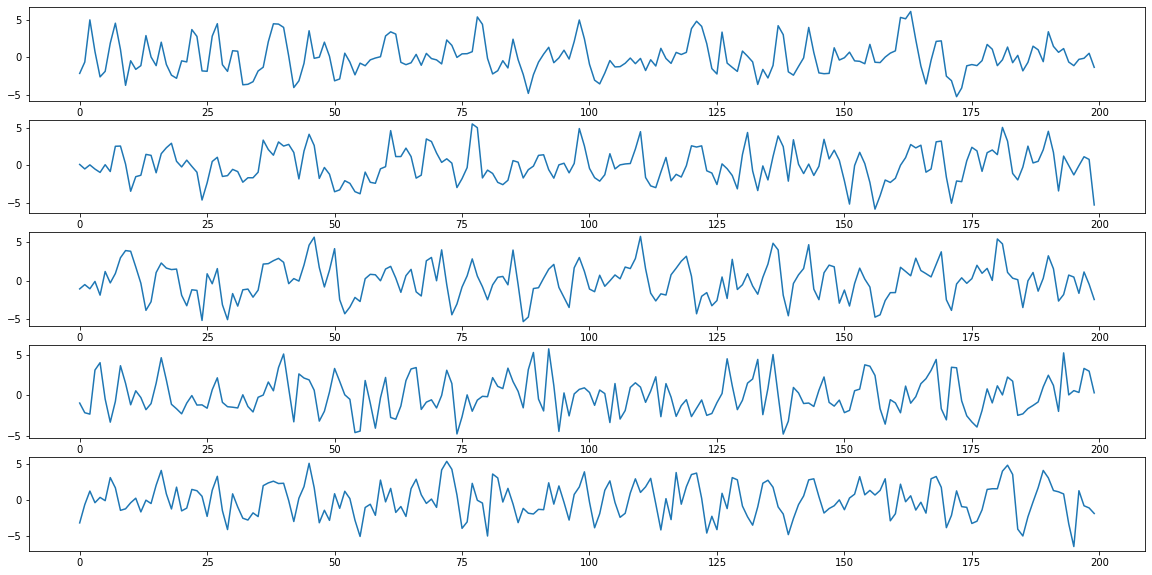

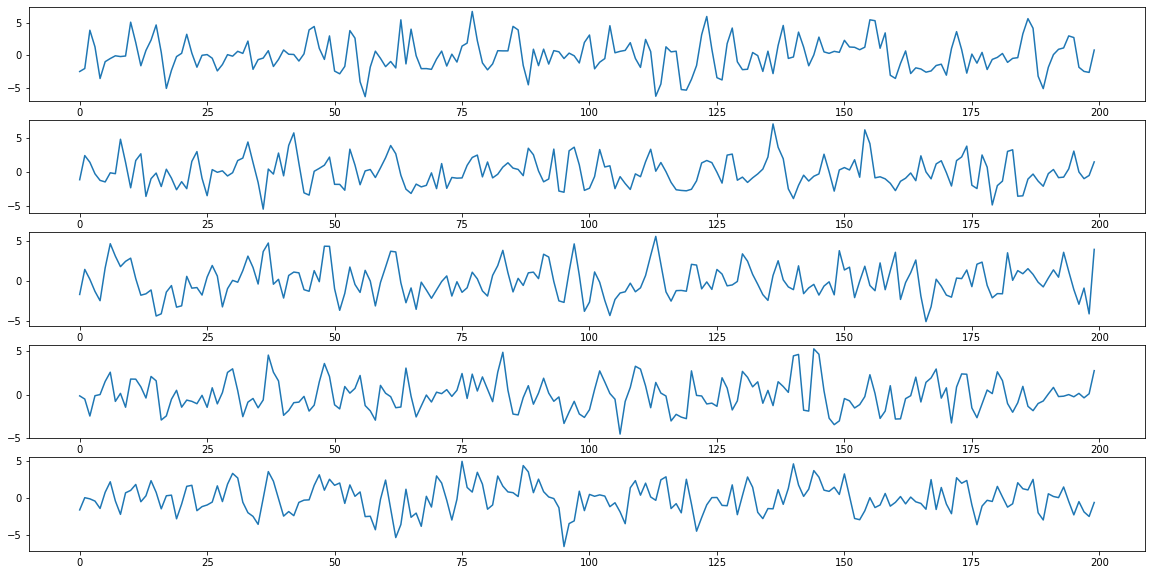

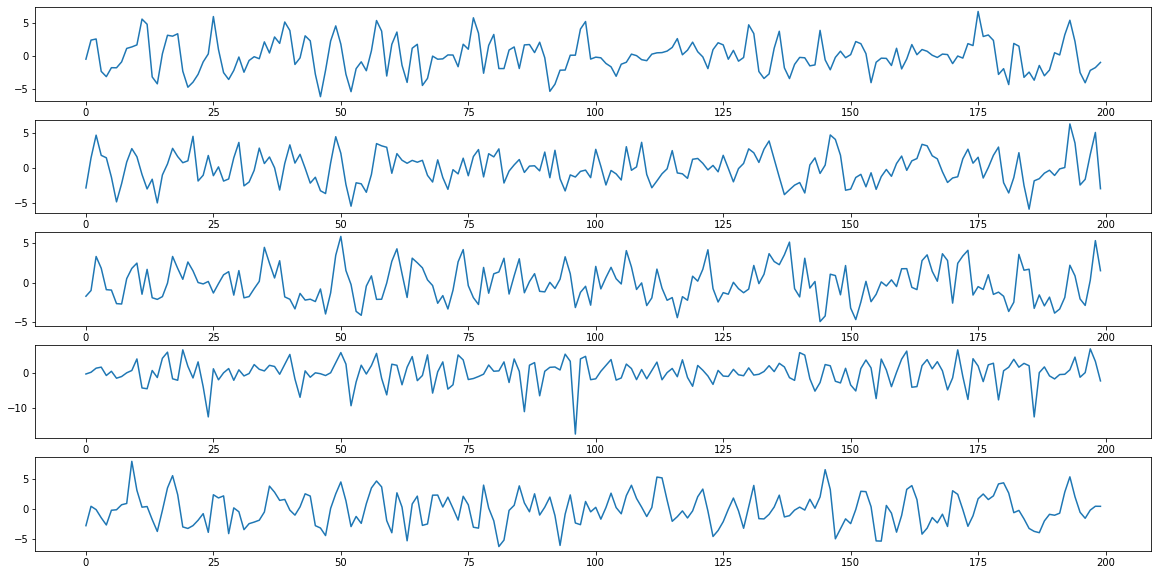

In [4]:
n_points = 200
for sub in range(10):
    plt.figure(figsize=(20,10))
    for i in range(5):
        plt.subplot(5,1,i+1)
        plt.plot(sim1_ts[n_points * sub: n_points * (sub + 1),i])

In [5]:
print(sim1_ts.shape)
sim1_ts_reshape = np.reshape(sim1_ts, (50, 200, 5))
print(sim1_ts_reshape.shape)

(10000, 5)
(50, 200, 5)


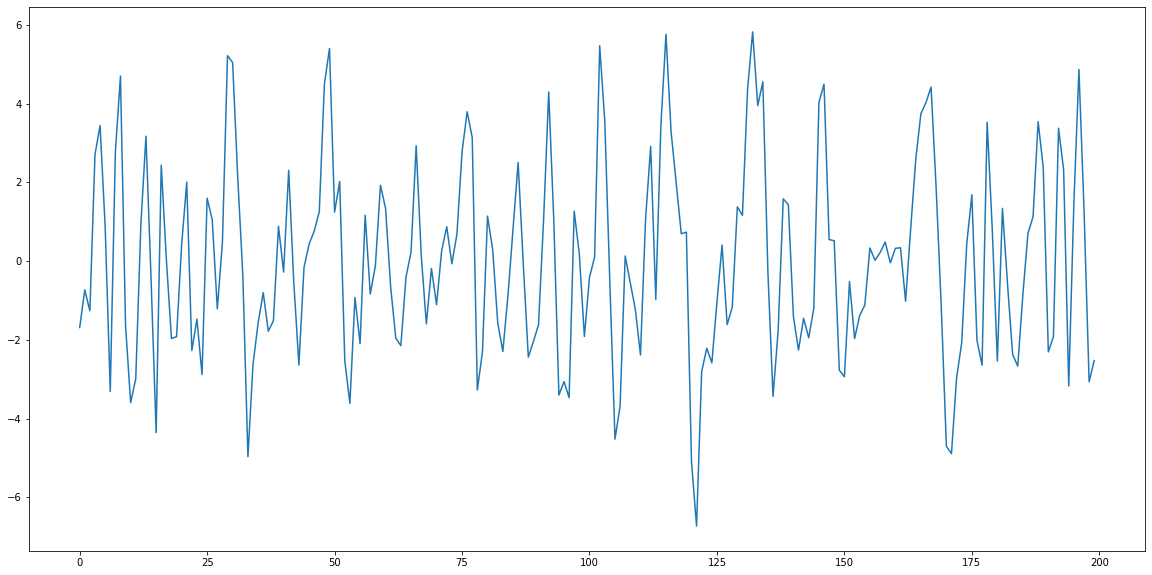

In [6]:
plt.figure(figsize=(20,10))
plt.plot(sim1_ts_reshape[0,:,0])

## Foolly  moving average prediction

### One step

In [154]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = input_data.shape[0]
    for i in range(L-tw):
        train_seq = input_data[i:i+tw, :]
        train_label = input_data[i+tw:i+tw+1, :]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

data = sim1_ts_reshape[0,:,:]
data = torch.FloatTensor(data)
window = 20
inout_seq = create_inout_sequences(data, window)
print(inout_seq[0][0].shape)
print(inout_seq[0][1].shape)

train_data = inout_seq[:100]
test_data = inout_seq[100:]

print('Training data size:', len(train_data))
print('Testing data size:', len(test_data))

class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=10, output_size=5):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        predictions = input_seq[-1,:]
        return predictions[-1]
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.eval()

test_loss = 0.0
for seq, labels in test_data:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
    #     print(single_loss.item())
        test_loss += single_loss.item()

test_loss /= len(test_data)
print(test_loss)

torch.Size([20, 5])
torch.Size([1, 5])
Training data size: 100
Testing data size: 80
10.136852189153434


/home/yons/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Multiple steps

In [155]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = input_data.shape[0]
    for i in range(L-tw):
        train_seq = input_data[i:i+tw, :]
        train_label = input_data[i+tw:i+tw+1, :]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

data = sim1_ts_reshape[0,:,:]
data = torch.FloatTensor(data)
window = 100
inout_seq = create_inout_sequences(data, window)
print(inout_seq[0][0].shape)
print(inout_seq[0][1].shape)

train_data = inout_seq[:40]
test_data = inout_seq[40:]

print('Training data size:', len(train_data))
print('Testing data size:', len(test_data))

g = 60
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=10, output_size=5):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        predictions = input_seq[-g:,:].mean(dim=0, keepdims=True)
#         print(input_seq.shape, predictions.mean(dim=0, keepdims=True).shape)
        return predictions
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.eval()

test_loss = 0.0
for seq, labels in test_data:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
    #     print(single_loss.item())
        test_loss += single_loss.item()

test_loss /= len(test_data)
print(test_loss)

torch.Size([100, 5])
torch.Size([1, 5])
Training data size: 40
Testing data size: 60
5.704815589388212


## LSTM predictor

### Create input data

In [94]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = input_data.shape[0]
    for i in range(L-tw):
        train_seq = input_data[i:i+tw, :]
        train_label = input_data[i+tw:i+tw+1, :]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [102]:
data = sim1_ts_reshape[0,:,:]
data = torch.FloatTensor(data)
window = 40
inout_seq = create_inout_sequences(data, window)
print(inout_seq[0][0].shape)
print(inout_seq[0][1].shape)

torch.Size([40, 5])
torch.Size([1, 5])


In [103]:
train_data = inout_seq[:100]
test_data = inout_seq[100:]

print('Training data size:', len(train_data))
print('Testing data size:', len(test_data))

Training data size: 100
Testing data size: 60


### Create large dataset with multiple individuals

In [7]:
def create_inout_sequences(inout_seq, input_data, tw):
    L = input_data.shape[0]
    for i in range(L-tw):
        train_seq = input_data[i:i+tw, :]
        train_label = input_data[i+tw:i+tw+1, :]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

window = 20
n_dims = 5
inout_seq = []
for i in range(50):
    data = sim1_ts_reshape[i,:,:]
    data = torch.FloatTensor(data)
    create_inout_sequences(inout_seq, data, window)
#     print(len(inout_seq))

print(len(inout_seq))
print('sample size', inout_seq[0][0].shape)
print('label size', inout_seq[0][1].shape)

# We mixed the data from different individuals as training data or testing data
# This makes the problem easier.
train_inds = []
for i in range(50):
    train_inds.extend(list(range(i*(200-window), i*(200-window)+100)))
test_inds = []
for i in range(50):
    test_inds.extend(list(range(i*(200-window)+100, (i+1)*(200-window))))
train_data = [inout_seq[i] for i in train_inds]
test_data = [inout_seq[i] for i in test_inds]

print('Training data size:', len(train_data))
print('Testing data size:', len(test_data))

9000
torch.Size([20, 5])
torch.Size([1, 5])
Training data size: 5000
Testing data size: 4000


Define the batches in training data

In [8]:
batch_size = 20
n_batches = int(len(train_data) / batch_size)
 
train_data_batched = []
for i in range(n_batches):
    train_data_batched.append((torch.zeros([window, batch_size, n_dims]), torch.zeros([1, batch_size, n_dims])))
    for j in range(batch_size):
        train_data_batched[i][0][:,j,:] = train_data[i*batch_size+j][0]
        train_data_batched[i][1][:,j,:] = train_data[i*batch_size+j][1]

print(len(train_data_batched))

250


### Create artificial data

(200, 5)


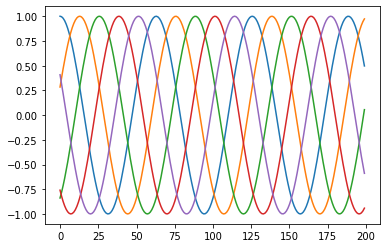

In [122]:
art_series = np.zeros((200, 5))
art_series[:,0] = np.cos(np.arange(200)/10)
art_series[:,1] = np.cos(np.arange(200)/10+5)
art_series[:,2] = np.cos(np.arange(200)/10+10)
art_series[:,3] = np.cos(np.arange(200)/10+15)
art_series[:,4] = np.cos(np.arange(200)/10+20)
plt.plot(art_series)
print(art_series.shape)

In [123]:
data = torch.FloatTensor(art_series)
window = 20
inout_seq = create_inout_sequences(data, window)

train_data = inout_seq[:100]
test_data = inout_seq[100:]

print('Training data size:', len(train_data))
print('Testing data size:', len(test_data))

Training data size: 100
Testing data size: 80


### Define and train LSTM

In [ ]:
class LSTM_naive(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=10, output_size=5):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,batch_size,self.hidden_layer_size),
                            torch.zeros(1,batch_size,self.hidden_layer_size))

    def forward(self, input_seq):
        # The input size of lstm should be (seq_len, batch, input_size)
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(input_seq.size()[0], batch_size, -1), self.hidden_cell) 
        predictions = self.linear(lstm_out[-1].view(batch_size, -1))
        return predictions

In [13]:
# Two-layer LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=10, output_size=5):
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,batch_size,self.hidden_layer_size),
                            torch.zeros(1,batch_size,self.hidden_layer_size))
        self.hidden_cell2 = (torch.zeros(1,batch_size,self.hidden_layer_size),
                            torch.zeros(1,batch_size,self.hidden_layer_size))

    def forward(self, input_seq):
        # The input size of lstm should be (seq_len, batch, input_size)
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(input_seq.size()[0], batch_size, -1), self.hidden_cell) 
        lstm_out2, self.hidden_cell2 = self.lstm2(lstm_out, self.hidden_cell2) 
#         print(lstm_out.shape)
        predictions = self.linear(lstm_out2[-1].view(batch_size, -1))
#         print(predictions.shape)
        return predictions


In [14]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(5, 10)
  (lstm2): LSTM(10, 10)
  (linear): Linear(in_features=10, out_features=5, bias=True)
)


In [15]:
epochs = 30

batch_size = 20
for i in range(epochs):
    running_loss = 0.0
    for seq, labels in train_data_batched:
        model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                        torch.zeros(1, batch_size, model.hidden_layer_size))
        optimizer.zero_grad()

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += single_loss.item()
    
    avg_loss = running_loss / len(train_data_batched)
    print(f'epoch: {i:3} loss: {avg_loss:10.6f}')


epoch:   0 loss:   5.164572
epoch:   1 loss:   5.002518
epoch:   2 loss:   4.782479
epoch:   3 loss:   4.677737
epoch:   4 loss:   4.612807
epoch:   5 loss:   4.564017
epoch:   6 loss:   4.524006
epoch:   7 loss:   4.489715
epoch:   8 loss:   4.458863
epoch:   9 loss:   4.430392
epoch:  10 loss:   4.404129
epoch:  11 loss:   4.379947
epoch:  12 loss:   4.357474
epoch:  13 loss:   4.336166
epoch:  14 loss:   4.315634
epoch:  15 loss:   4.295716
epoch:  16 loss:   4.276470
epoch:  17 loss:   4.258087
epoch:  18 loss:   4.240587
epoch:  19 loss:   4.223758
epoch:  20 loss:   4.207343
epoch:  21 loss:   4.191174
epoch:  22 loss:   4.175183
epoch:  23 loss:   4.159380
epoch:  24 loss:   4.143853
epoch:  25 loss:   4.128778
epoch:  26 loss:   4.114427
epoch:  27 loss:   4.101120
epoch:  28 loss:   4.089115
epoch:  29 loss:   4.078508


In [223]:
model.eval()

batch_size = 1
test_loss = 0.0
for seq, labels in test_data:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
    #     print(single_loss.item())
        test_loss += single_loss.item()

test_loss /= len(test_data)
print(test_loss)

4.318305773831904
